In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [39]:
import tensorflow as tf
import h5py
import numpy as np
import pandas as pd
import os
import scipy.stats as ss
import src
from src.transfer_learn import KinnLayer, amber_app
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
from tqdm import tqdm
from sklearn.metrics import average_precision_score
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
with h5py.File("./data/inVivoData.newValidSplit.h5", "r") as store:
    t1 = store["test/Kleinsitver_mut/x"][()], store["test/Kleinsitver_mut/y"][()]
    t2 = store["test/Listgarten_mut/x"][()], store["test/Listgarten_mut/y"][()]
    t3 = store["test/Listgarten_indel/x"][()], store["test/Listgarten_indel/y"][()]
    valid_data = store["valid/x"][()], store["valid/y"][()]

In [4]:
target_wds = [f"outputs/2022-10-31/TL_{i}" for i in range(4,7)]
target_wds

['outputs/2022-10-31/TL_4',
 'outputs/2022-10-31/TL_5',
 'outputs/2022-10-31/TL_6']

In [47]:
def load_model_and_benchmark(amb, wd, arc_seq, return_preds=False):
    tf.reset_default_graph()
    train_graph = tf.Graph()
    train_sess = tf.Session(graph=train_graph)
    with train_graph.as_default(), train_sess.as_default():
        model = amb.model_fn(arc_seq)
        model.load_weights(os.path.join(wd, "bestmodel.h5"))
        benchmarks = {
            "Kleinsitver": model.predict(t1[0], batch_size=25000).flatten() if return_preds else amb.reward_fn(model, t1)[0],
            "Listgarten": model.predict(t2[0], batch_size=25000).flatten() if return_preds else amb.reward_fn(model, t2)[0],
            "Listgarten_Indel": model.predict(t3[0], batch_size=25000).flatten() if return_preds else amb.reward_fn(model, t3)[0],
            "Valid": model.predict(valid_data[0], batch_size=25000).flatten() if return_preds else amb.reward_fn(model, valid_data)[0],
        }
    tf.keras.backend.clear_session()
    return benchmarks

def load_model_ensemble_predict(amb, arc_wd_pairs):
    preds = {}
    for arc, wd in arc_wd_pairs:
        pred = load_model_and_benchmark(amb, wd, arc, return_preds=True)
        preds[wd] = pred
    return preds

def ensemble_benchmark(ensemble_preds):
    preds = {}
    label_dict = {"Kleinsitver": t1[1], "Listgarten": t2[1], "Listgarten_Indel": t3[1], "Valid": valid_data[1]}
    for cls in ensemble_preds:
        for ds in ensemble_preds[cls]:
            if ds in preds:
                preds[ds].append(ensemble_preds[cls][ds])
            else:
                preds[ds] = [ensemble_preds[cls][ds]]
    benchmarks = {}
    for ds in preds:
        y_score = np.array(preds[ds]).mean(axis=0)
        benchmarks[ds] = average_precision_score(label_dict[ds], y_score)
    return benchmarks

In [6]:
def retrain_model(amb, arc_seq, target_wd, trial_id, finetune=True, verbose=1):
    model = amb.model_fn(arc_seq)
    if finetune:
        model.load_weights(os.path.join(target_wd, "weights", "trial_%i"%trial_id, "bestmodel.h5"))
    batch_size = 25000
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005 if finetune else 0.005,
        decay_steps=int(1000000/batch_size)*10,  # decay lr every 10 epochs
        decay_rate=0.9,
        staircase=False)
    opt = Adam(learning_rate=lr_schedule) if finetune else Adam(learning_rate=lr_schedule)
    model.compile(**{
        'loss': 'binary_crossentropy', 
        'metrics': ['acc', tf.keras.metrics.AUC(curve='PR', name='auc_1')],
        'optimizer': opt,
    })
    wd = os.path.join(target_wd, "weights", "trial_%i"%trial_id)
    init_val_thresh = model.evaluate(amb.manager.validation_data[0], amb.manager.validation_data[1], batch_size=batch_size)[-1]
    print("init val thresh:", init_val_thresh)
    checkpointer = ModelCheckpoint(
        filepath=os.path.join(wd, "bestmodel_retrain.h5"), 
        monitor="val_auc_1",
        mode='max',
        initial_value_threshold=init_val_thresh,
        verbose=verbose, 
        save_best_only=True, 
        save_weights_only=True)
    checkpointer.best = init_val_thresh
    if os.path.isfile(os.path.join(wd, "bestmodel_retrain.h5")):
        os.remove(os.path.join(wd, "bestmodel_retrain.h5"))
    earlystopper = EarlyStopping(monitor="val_auc_1", mode='max', patience=5 if finetune else 15, verbose=verbose)
    earlystopper.best = init_val_thresh
    hist = model.fit(
        amb.manager.train_data[0],
        amb.manager.train_data[1],
        epochs=500,
        batch_size=batch_size,
        validation_data=amb.manager.validation_data,
        callbacks=[checkpointer, earlystopper],
        verbose=verbose
    )
    return model, hist

def plot_hist(trial_id, model, hist, amb, wd, do_plot=True):
    try:
        model.load_weights(os.path.join(wd,"bestmodel_retrain.h5"))
        print("loaded retrained weights")
    except:
        #model.load_weights(os.path.join(wd,"bestmodel.h5"))
        print("retrain did not improve valid performance")
    retrain_benchmarks = {
        "Kleinsitver": amb.reward_fn(model, t1)[0],
        "Listgarten": amb.reward_fn(model, t2)[0],
        "Listgarten_Indel": amb.reward_fn(model, t3)[0],
        "Valid": amb.reward_fn(model, valid_data)[0]
    }
    if do_plot:
        fig, axs = plt.subplots(1,2, figsize=(8,4))
        axs[0].plot(hist.history['loss'], label="train")
        axs[0].plot(hist.history['val_loss'], label="valid")
        axs[0].legend()
        axs[0].set_title('model loss')
        auc_key = [k for k in hist.history if k.startswith('auc')][0]
        axs[1].plot(hist.history[auc_key], label="train")
        axs[1].plot(hist.history['val_' + auc_key], label="valid")
        axs[1].legend()
        axs[1].set_title('model auc')
    return retrain_benchmarks

In [7]:
if os.path.isdir("weights"):
    os.rmdir("weights")
amb = amber_app(wd=".", run=False)
# clean up folders created by trainEnv
os.rmdir("weights")

BUILDING
----------


2022-11-01 22:09:01,050 - AMBER - INFO -
 time budget set to: 72:00:00


controller = GeneralController
modeler = <class 'src.transfer_learn.TransferKinnModelBuilder'>
knowledge = zero
reward = LossAucReward
manager = GeneralManager
env_type = ControllerTrainEnv


In [8]:
# optionally, load model space from disk
%run src/transfer_learn
with open(os.path.join(target_wds[0], "model_space.pkl"), "rb") as f:
    model_space, _ = pickle.load(f)
amb.model_fn.model_space = model_space
amb.model_space = model_space

In [9]:
print("total model space size: %i"%np.prod([len(x) for x in amb.model_space]))

total model space size: 124416


In [10]:
bm_df = []
n_tail = 200
for target_wd in target_wds:
    train_hist = pd.read_table(os.path.join(target_wd, "train_history.csv"), sep=",", header=None)
    for i in tqdm(train_hist.tail(n_tail).index):
        trial_id = train_hist.loc[i, 0]
        arc_seq = train_hist.loc[i, 3:].tolist()
        #print(i, trial_id, arc_seq)
        wd = os.path.join(target_wd, "weights", "trial_%i"%trial_id)
        benchmarks = load_model_and_benchmark(amb=amb, wd=wd, arc_seq=arc_seq)
        benchmarks.update({
            'arc': arc_seq,
            'Valid_amber': train_hist.loc[i, 2],
            'trial': trial_id,
            'wd': target_wd, #'_'.join(target_wd.split('/')[1:]),
        })
        bm_df.append(benchmarks)

100%|██████████| 200/200 [24:30<00:00,  7.35s/it]


In [11]:
bm_df = pd.DataFrame(bm_df)

In [51]:
bm_df = bm_df.sort_values('Valid', ascending=False)
bm_df.head(20)

,Kleinsitver,Listgarten,Listgarten_Indel,Valid,arc,Valid_amber,trial,wd
357,0.313208,0.135214,0.229298,0.427797,"[0, 0, 0, 2, 1, 0, 1, 0]",0.427797,257,outputs/2022-10-31/TL_5
555,0.151631,0.071993,0.175710,0.425122,"[0, 3, 0, 3, 0, 0, 1, 4]",0.425122,255,outputs/2022-10-31/TL_6
489,0.082953,0.070342,0.210326,0.424914,"[0, 2, 0, 2, 0, 0, 1, 4]",0.424914,189,outputs/2022-10-31/TL_6
165,0.168169,0.162058,0.210348,0.424840,"[1, 1, 5, 2, 5, 0, 1, 3]",0.424840,265,outputs/2022-10-31/TL_4
431,0.272029,0.196873,0.252077,0.423216,"[0, 2, 0, 2, 0, 0, 1, 5]",0.423216,131,outputs/2022-10-31/TL_6
193,0.330611,0.190617,0.232860,0.421035,"[1, 0, 5, 2, 5, 0, 1, 5]",0.421035,293,outputs/2022-10-31/TL_4
535,0.200071,0.101782,0.247273,0.417719,"[0, 2, 0, 2, 0, 0, 1, 4]",0.417719,235,outputs/2022-10-31/TL_6
490,0.199077,0.134756,0.219449,0.415746,"[0, 0, 0, 2, 0, 0, 1, 4]",0.415746,190,outputs/2022-10-31/TL_6
574,0.156949,0.062679,0.181227,0.413868,"[0, 2, 0, 3, 0, 0, 1, 4]",0.413868,274,outputs/2022-10-31/TL_6
512,0.256114,0.113567,0.172692,0.410035,"[0, 2, 0, 2, 0, 0, 1, 5]",0.410035,212,outputs/2022-10-31/TL_6


Text(0.5, 1.0, 'spm=1.000')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


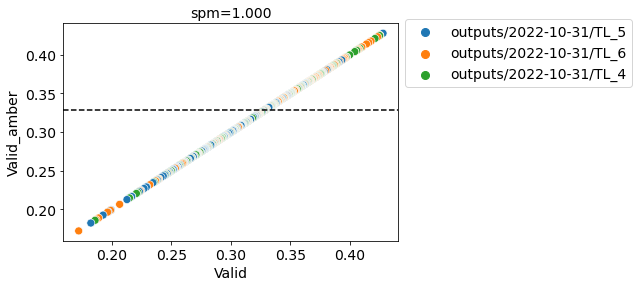

In [13]:
ax = sns.scatterplot(x='Valid', y='Valid_amber', data=bm_df, hue='wd')
ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
ax.axhline(y=0.329, ls='--', color='k')
ax.set_title("spm=%.3f"%ss.spearmanr(bm_df['Valid'], bm_df['Valid_amber']).correlation)

In [14]:
bm_df[['Kleinsitver', 'Listgarten', 'Listgarten_Indel', 'Valid']].corr()

,Kleinsitver,Listgarten,Listgarten_Indel,Valid
Kleinsitver,1.000000,0.531710,0.168929,0.377327
Listgarten,0.531710,1.000000,0.362086,0.415444
Listgarten_Indel,0.168929,0.362086,1.000000,0.022475
Valid,0.377327,0.415444,0.022475,1.000000


Text(0.5, 1.0, 'spm=0.375')

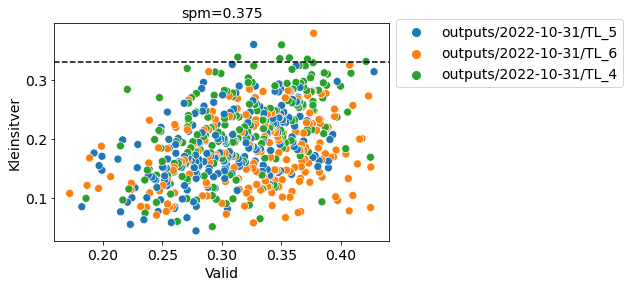

In [15]:
ax = sns.scatterplot(x='Valid', y='Kleinsitver', data=bm_df, hue='wd')
ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
ax.axhline(y=0.329, ls='--', color='k')
ax.set_title("spm=%.3f"%ss.spearmanr(bm_df['Valid'], bm_df['Kleinsitver']).correlation)

Text(0.5, 1.0, 'spm=0.419')

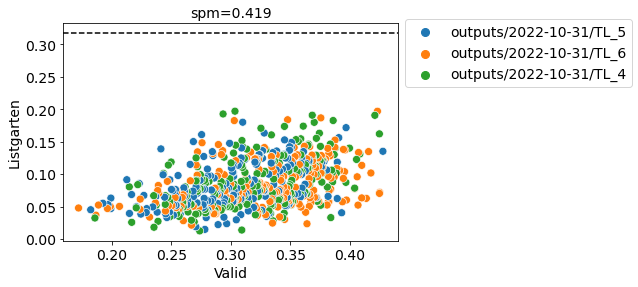

In [16]:
ax=sns.scatterplot(x='Valid', y='Listgarten', data=bm_df, hue='wd')
ax.axhline(y=0.317, ls='--', color='k')
ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
ax.set_title("spm=%.3f"%ss.spearmanr(bm_df['Valid'], bm_df['Listgarten']).correlation)

Text(0.5, 1.0, 'spm=-0.025')

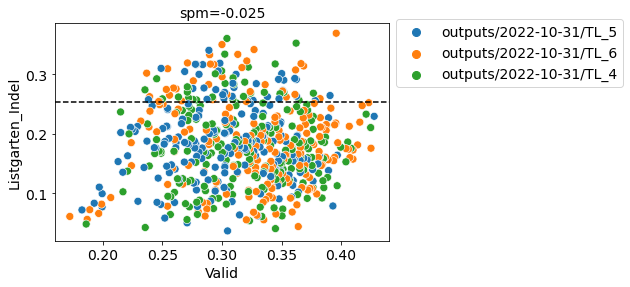

In [17]:
ax=sns.scatterplot(x='Valid', y='Listgarten_Indel', data=bm_df, hue='wd')
ax.axhline(y=0.254, ls='--', color='k')
ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
ax.set_title("spm=%.3f"%ss.spearmanr(bm_df['Valid'], bm_df['Listgarten_Indel']).correlation)

For retraining - it does not improve the performance, though
```python
i = 0
arc_seq, target_wd, trial_id = bm_df.iloc[i][['arc', 'wd','trial']]
wd = os.path.join(target_wd, "weights", "trial_%i"%trial_id)
model, hist = retrain_model(amb, arc_seq, target_wd=target_wd, trial_id=trial_id)
plot_hist(trial_id, model, hist, amb, wd)
```

In [73]:
kleinsitver_cutoff = 0.202
listgarten_cutoff = 0.079
listgarten_cutoff2 = 0.100
n_max_models = 10
target_model_id = []
for i in bm_df.index:
    # skip if transfer learning CNN didn't improve upon base KINN
    if bm_df.loc[i, 'Kleinsitver'] < kleinsitver_cutoff or bm_df.loc[i, 'Listgarten'] < listgarten_cutoff or bm_df.loc[i, 'Listgarten_Indel'] < listgarten_cutoff2:
        continue
    target_model_id.append(i)
    if len(target_model_id) >= n_max_models:
        print("break due to max models")
        break

break due to max models


In [74]:
#target_model_id = [357, 431, 193, 512, 131, 478]
bm_df.loc[target_model_id]

,Kleinsitver,Listgarten,Listgarten_Indel,Valid,arc,Valid_amber,trial,wd
357,0.313208,0.135214,0.229298,0.427797,"[0, 0, 0, 2, 1, 0, 1, 0]",0.427797,257,outputs/2022-10-31/TL_5
431,0.272029,0.196873,0.252077,0.423216,"[0, 2, 0, 2, 0, 0, 1, 5]",0.423216,131,outputs/2022-10-31/TL_6
193,0.330611,0.190617,0.232860,0.421035,"[1, 0, 5, 2, 5, 0, 1, 5]",0.421035,293,outputs/2022-10-31/TL_4
512,0.256114,0.113567,0.172692,0.410035,"[0, 2, 0, 2, 0, 0, 1, 5]",0.410035,212,outputs/2022-10-31/TL_6
131,0.310653,0.130991,0.175611,0.408421,"[1, 1, 5, 0, 5, 0, 1, 5]",0.408421,231,outputs/2022-10-31/TL_4
478,0.324545,0.133361,0.159995,0.407357,"[0, 2, 0, 2, 0, 0, 1, 5]",0.407357,178,outputs/2022-10-31/TL_6
160,0.244783,0.122639,0.186149,0.405636,"[1, 0, 5, 0, 5, 0, 1, 5]",0.405636,260,outputs/2022-10-31/TL_4
62,0.288730,0.140058,0.177470,0.399712,"[5, 0, 5, 0, 0, 0, 1, 2]",0.399712,162,outputs/2022-10-31/TL_4
274,0.296708,0.171599,0.164045,0.396853,"[0, 1, 0, 0, 0, 0, 1, 5]",0.396853,174,outputs/2022-10-31/TL_5
172,0.236289,0.087354,0.112738,0.396703,"[1, 1, 0, 2, 5, 0, 1, 5]",0.396703,272,outputs/2022-10-31/TL_4


In [75]:
arc_wd_pairs = [(row['arc'], os.path.join(row['wd'], 'weights', 'trial_%i'%row['trial']))  for _, row in bm_df.loc[target_model_id].iterrows()]
ensemble_preds = load_model_ensemble_predict(amb, arc_wd_pairs)

In [77]:
tmp = {}
incremental_benchmark = []
for cls in ensemble_preds:
    tmp.update({cls:ensemble_preds[cls]})
    res = ensemble_benchmark(tmp)
    res.update({'n_models': len(tmp)})
    incremental_benchmark.append(res)

Text(0.5, 1.0, 'Model ensemble vs Test performance')

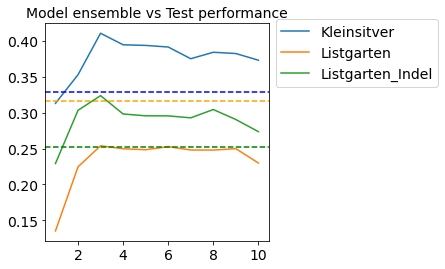

In [87]:
incremental_benchmark_df = pd.DataFrame(incremental_benchmark, index=np.arange(len(incremental_benchmark)))

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(incremental_benchmark_df['n_models'], incremental_benchmark_df['Kleinsitver'], label='Kleinsitver')
ax.axhline(y=0.329, ls='--', color='blue')

ax.plot(incremental_benchmark_df['n_models'], incremental_benchmark_df['Listgarten'], label='Listgarten')
ax.axhline(y=0.317, ls='--', color='orange')

ax.plot(incremental_benchmark_df['n_models'], incremental_benchmark_df['Listgarten_Indel'], label='Listgarten_Indel')
ax.axhline(y=0.252, ls='--', color='green')


ax.legend(loc='upper left', bbox_to_anchor=(1, 1.05))
ax.set_title("Model ensemble vs Test performance")

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Nov 01 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

pandas    : 1.0.3
argparse  : 1.1
h5py      : 2.10.0
scipy     : 1.7.3
src       : 0.0.3
seaborn   : 0.11.1
matplotlib: 3.4.3
tensorflow: 1.15.0
numpy     : 1.19.5

Watermark: 2.3.1

